In [ ]:
#用到的数据：
# mcap.csv: 从研究报告（表1）中得到的10个行业的名字以及各个行业的市值（市值单位：亿元）
# market_prices.cvs: 2019/1/2-2019/12/31 10个行业的申万指数
# ZZ500: 

In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt as pyp
import seaborn as sns
import datetime
import yfinance as yf
idx = pd.IndexSlice

from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import black_litterman, risk_models

In [250]:
data = pd.read_csv('market prices.csv',index_col = 0)
market_cap = pd.read_csv('mcap.csv')

market_prices = pd.DataFrame(data)
mcap = pd.DataFrame(market_cap)

mcap.head()

,Tickers,Market Cap
0,医药生物,20492
1,电子,18290
2,银行,25943
3,食品饮料,15468
4,计算机,11907


In [251]:
#create market cap dict
mcap_dict = {ticker : cap for ticker, cap in zip(mcap['Tickers'].values, mcap['Market Cap'].values)}
print(mcap_dict)

{'医药生物': 20492, '电子': 18290, '银行': 25943, '食品饮料': 15468, '计算机': 11907, '房地产': 11038, '传媒': 8205, '家用电器': 7948, '电气设备': 8448, '汽车': 6812}


In [252]:
S = pyp.risk_models.sample_cov(market_prices, returns_data=False, frequency=252, log_returns=False)
print(S)

          医药生物        电子        银行      食品饮料       计算机       房地产        传媒  \
医药生物  0.050924  0.050241  0.018146  0.043505  0.053381  0.035425  0.044975   
电子    0.050241  0.094725  0.022412  0.044142  0.090021  0.041912  0.066369   
银行    0.018146  0.022412  0.030207  0.022931  0.022169  0.025644  0.019619   
食品饮料  0.043505  0.044142  0.022931  0.068120  0.039197  0.034490  0.034046   
计算机   0.053381  0.090021  0.022169  0.039197  0.116315  0.047211  0.076649   
房地产   0.035425  0.041912  0.025644  0.034490  0.047211  0.050827  0.042104   
传媒    0.044975  0.066369  0.019619  0.034046  0.076649  0.042104  0.075479   
家用电器  0.041855  0.048374  0.026693  0.044260  0.051083  0.042412  0.040846   
电气设备  0.039712  0.061900  0.019600  0.033343  0.069028  0.039635  0.053652   
汽车    0.040663  0.054501  0.022140  0.035903  0.058657  0.039042  0.046238   

          家用电器      电气设备        汽车  
医药生物  0.041855  0.039712  0.040663  
电子    0.048374  0.061900  0.054501  
银行    0.026693  0.019600  0.02

In [253]:
#风险厌恶 delta
prices_csv = pd.read_csv('ZZ500.csv')
prices = pd.DataFrame(prices_csv,columns = ['date','prices'])
prices['prices'].astype(float)


#,index_col =[0], parse_dates=True
#prices = pd.DataFrame(prices)
#prices['prices'] = prices['prices'].astype(float)
prices['date'] = pd.to_datetime(prices['date'])
prices.set_index('date', inplace=True)
prices1 = prices['prices']
type(prices1)
prices1

date
2019-01-02    4131.9567
2019-01-03    4112.8070
2019-01-04    4210.8786
2019-01-07    4288.3234
2019-01-08    4277.2967
                ...    
2019-12-25    5183.0986
2019-12-26    5219.1404
2019-12-27    5179.1929
2019-12-30    5241.9383
2019-12-31    5267.6622
Name: prices, Length: 244, dtype: float64

In [254]:
#S = pyp.risk_models.CovarianceShrinkage(market_prices).ledoit_wolf()
#print(S)

In [255]:
delta = pyp.black_litterman.market_implied_risk_aversion(prices1,risk_free_rate=0.05)
print(delta)

4.183980814874176


In [256]:
market_prior = black_litterman.market_implied_prior_returns(mcap_dict, delta,S)
market_prior.name = 'Prior'
print(market_prior)

医药生物    0.189376
电子      0.249612
银行      0.118159
食品饮料    0.186432
计算机     0.263963
房地产     0.178520
传媒      0.214682
家用电器    0.197494
电气设备    0.201863
汽车      0.193539
Name: Prior, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21307 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 33647 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 29289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 30005 missing from c

Text(0.5, 1.0, 'Assets Correlation Matrix')

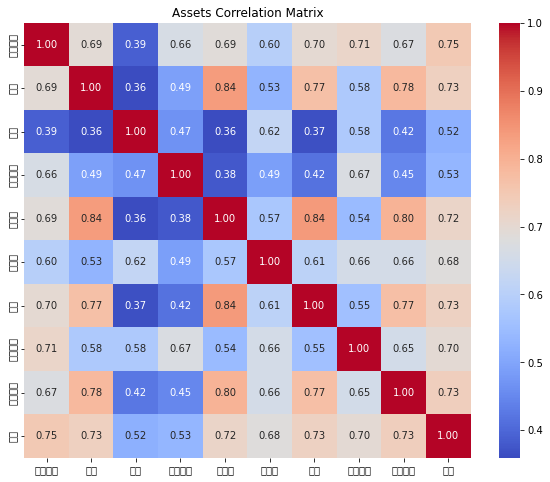

In [257]:
#heatmap of mcaps

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(market_prices.pct_change().corr(method ='spearman'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f")
ax.set_title('Assets Correlation Matrix')


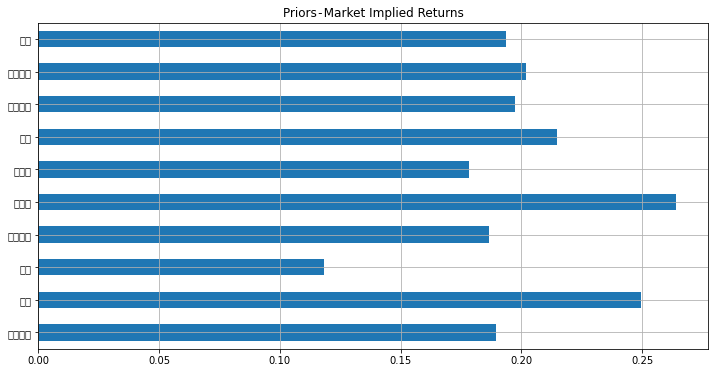

In [258]:
# plot prior
market_prior.plot.barh(figsize=(12,6), title = 'Priors - Market Implied Returns',grid=True);


In [259]:
P = np.array([[0,0,0,0,0,0,0,0,0,1],
            [0,0,0,0,0,0,1,0,0,0],
            [0,0,0,1,0,0,0,-1,0,0],
            [0,0.5,-0.7,0,0.3,-0.3,0,0,0.2,0],
            ])
Q = np.array([0.06,0.04,-0.01,0.02]).reshape(-1,1)

In [260]:
confidence = np.array([0.5,0.6,0.2,0.6])


In [261]:
#run the bl model
bl = pyp.BlackLittermanModel(S,pi=market_prior, absolute_views=None,Q = Q,P=P,omega='idzorek',view_confidences=confidence,tau=0.025,risk_aversion=delta.all()) 

In [262]:
bl.omega

array([[0.00142849, 0.        , 0.        , 0.        ],
       [0.        , 0.00125798, 0.        , 0.        ],
       [0.        , 0.        , 0.00430851, 0.        ],
       [0.        , 0.        , 0.        , 0.00096946]])

In [263]:
# Posterior estimate of returns
bl_return = bl.bl_returns()
bl_return.name = 'Posterior'
print(bl_return)

医药生物    0.106999
电子      0.126337
银行      0.084713
食品饮料    0.120794
计算机     0.125936
房地产     0.105366
传媒      0.092773
家用电器    0.120691
电气设备    0.105235
汽车      0.098996
Name: Posterior, dtype: float64


In [264]:
# get historical returns
mu = pyp.expected_returns.mean_historical_return(market_prices)
mu.name = 'Historical'
print(mu)

医药生物    0.498260
电子      0.898340
银行      0.319935
食品饮料    0.835654
计算机     0.741016
房地产     0.281718
传媒      0.481266
家用电器    0.441150
电气设备    0.260605
汽车      0.169255
Name: Historical, dtype: float64


In [265]:
# create returns dataframe
returns_df = pd.DataFrame([market_prior, mu, bl_return], 
             index=['Prior', 'Historical','Posterior']).T
print(returns_df)

# write it for future reference
returns_df.to_csv('returns.csv', header=True,)
returns_df = pd.read_csv('returns.csv', index_col=[0], )

         Prior  Historical  Posterior
医药生物  0.189376    0.498260   0.106999
电子    0.249612    0.898340   0.126337
银行    0.118159    0.319935   0.084713
食品饮料  0.186432    0.835654   0.120794
计算机   0.263963    0.741016   0.125936
房地产   0.178520    0.281718   0.105366
传媒    0.214682    0.481266   0.092773
家用电器  0.197494    0.441150   0.120691
电气设备  0.201863    0.260605   0.105235
汽车    0.193539    0.169255   0.098996


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21307 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 33647 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 29289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 30005 missing from c

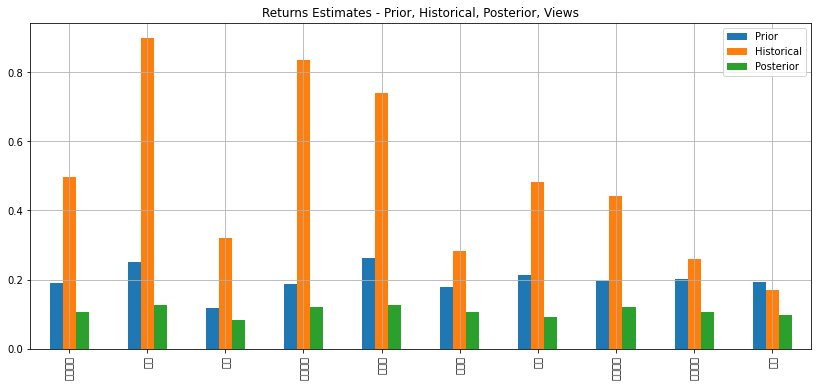

In [266]:
# plot the returns
returns_df.plot.bar(figsize=(14,6), title = 'Returns Estimates - Prior, Historical, Posterior, Views', grid=True);
plt.savefig('chart3', dpi=300)

In [267]:
# get the posterior covariance matrix
S_bl = bl.bl_cov()
S_bl.to_csv('S_bl.csv')
S_bl = pd.read_csv('S_bl.csv',  index_col=[0])
S_bl


,医药生物,电子,银行,食品饮料,计算机,房地产,传媒,家用电器,电气设备,汽车
医药生物,0.051620,0.050631,0.018371,0.044125,0.053755,0.035807,0.045276,0.042363,0.040032,0.041002
电子,0.050631,0.095644,0.022752,0.044608,0.090663,0.042289,0.066747,0.048817,0.062366,0.054875
银行,0.018371,0.022752,0.030758,0.023289,0.022470,0.025999,0.019808,0.027086,0.019872,0.022389
食品饮料,0.044125,0.044608,0.023289,0.069366,0.039490,0.034940,0.034278,0.044962,0.033686,0.036257
计算机,0.053755,0.090663,0.022470,0.039490,0.117426,0.047633,0.077117,0.051495,0.069543,0.059029
房地产,0.035807,0.042289,0.025999,0.034940,0.047633,0.051588,0.042440,0.042946,0.040065,0.039400
传媒,0.045276,0.066747,0.019808,0.034278,0.077117,0.042440,0.076086,0.041111,0.053994,0.046480
家用电器,0.042363,0.048817,0.027086,0.044962,0.051495,0.042946,0.041111,0.064492,0.044282,0.044778
电气设备,0.040032,0.062366,0.019872,0.033686,0.069543,0.040065,0.053994,0.044282,0.063682,0.044166
汽车,0.041002,0.054875,0.022389,0.036257,0.059029,0.039400,0.046480,0.044778,0.044166,0.057714


In [268]:
# get the weights implied by the posterior returns
weights_bl = bl.bl_weights(risk_aversion = delta)
weights_bl


OrderedDict([('医药生物', 0.2852426852973758),
             ('电子', 0.10421997647173947),
             ('银行', 0.4981246091856818),
             ('食品饮料', 0.12654895999797414),
             ('计算机', 0.05579943710132379),
             ('房地产', 0.10831262178111287),
             ('传媒', -0.22762060535187587),
             ('家用电器', 0.04601988250175356),
             ('电气设备', 0.12717353553802901),
             ('汽车', -0.12382110252311465)])